In [1]:
import tensorflow as tf #importowanie wymaganych bibliotek
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('integrated_data.csv')#wczytanie pliku


print("Dane przed usunięciem NaN:",len(data), "liczba kolumn:",len(data.columns))#wyświetlenie liczby rekordów i kolumn
#data = data.drop('Wolumen_ftse250_d', 1)#usunięcie kolumny z pustymi wartościami
print(data[data.columns[data.isnull().any()]])
data['Zamkniecie'] = data['Zamkniecie'].shift(-1)#przesunięcie kolumny prognowanej o jeden indeks - prognoza ma być na nastęną sesję - można zmienić i prognozować na większą liczbę sesji do przodu
data = data.dropna()#usunięcie danych Not a number
print("Dane po usunięciu NaN:",len(data), "liczba kolumn:",len(data.columns))


Dane przed usunięciem NaN: 1823 liczba kolumn: 56
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[1823 rows x 0 columns]
Dane po usunięciu NaN: 1822 liczba kolumn: 56


In [3]:
print(data.head())#wyświetlenie nagłówka tabeli, aby sprawdzić poprawność poprzednich operacji na danych

         Data  Otwarcie  Najwyzszy  Najnizszy  Zamkniecie  Wolumen  \
0  2015-04-07    167.47     168.80     166.04      167.47    21756   
1  2015-04-08    166.04     168.55     165.56      165.29   111034   
2  2015-04-09    167.09     167.47     163.71      166.14    67434   
3  2015-04-10    165.09     167.75     165.09      170.49   135425   
4  2015-04-13    167.84     170.49     166.24      172.97    36857   

   Otwarcie_eah_d  Najwyzszy_eah_d  Najnizszy_eah_d  Zamkniecie_eah_d  ...  \
0         26.6746          26.6746          25.2033           25.4187  ...   
1         26.6746          26.6746          25.0394           25.0394  ...   
2         26.6746          31.6306          25.2380           30.0479  ...   
3         30.0994          30.3316          28.3949           29.6864  ...   
4         31.3215          31.3215          29.6864           29.6864  ...   

   Otwarcie_wig_d  Najwyzszy_wig_d  Najnizszy_wig_d  Zamkniecie_wig_d  \
0        54295.49         54699.04   

In [4]:
data.describe()

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Otwarcie_eah_d,Najwyzszy_eah_d,Najnizszy_eah_d,Zamkniecie_eah_d,Wolumen_eah_d,...,Otwarcie_wig_d,Najwyzszy_wig_d,Najnizszy_wig_d,Zamkniecie_wig_d,Wolumen_wig_d,Otwarcie_nke_us_d,Najwyzszy_nke_us_d,Najnizszy_nke_us_d,Zamkniecie_nke_us_d,Wolumen_nke_us_d
count,1822.000000,1822.000000,1822.000000,1822.000000,1.822000e+03,1822.000000,1822.000000,1822.000000,1822.000000,1822.000000,...,1822.000000,1822.000000,1822.000000,1822.000000,1.822000e+03,1822.000000,1822.000000,1822.000000,1822.000000,1.822000e+03
mean,138.455307,140.648814,135.925812,138.200049,2.041155e+05,21.113294,21.483315,20.451984,20.984046,4282.809457,...,56553.861795,56864.128353,56157.050488,56509.936636,5.004617e+07,88.642278,89.574006,87.713126,88.648884,8.128201e+06
std,71.672878,72.427036,70.841443,71.723782,3.256940e+05,12.460346,12.741514,12.076701,12.371960,9207.610311,...,7121.662851,7118.830621,7115.555315,7118.688698,2.024185e+07,35.530184,35.908598,35.113927,35.494000,4.597354e+06
min,26.000000,28.600000,24.300000,24.980000,8.068000e+03,5.562860,5.581590,5.319370,5.319370,1.067797,...,37770.040000,38031.230000,35588.110000,37164.020000,1.683693e+07,45.624800,45.762600,43.641500,45.387800,2.612955e+06
25%,65.925000,67.815000,63.205000,65.300000,6.797375e+04,10.769800,10.957100,10.395200,10.676200,568.868644,...,50982.485000,51314.692500,50638.380000,50982.400000,3.662073e+07,55.029700,55.592650,54.606000,55.055425,5.551745e+06
50%,132.340000,134.665000,128.580000,131.735000,1.156935e+05,18.261900,18.481950,17.640100,18.105500,1793.813559,...,57227.980000,57556.805000,56822.815000,57168.850000,4.522113e+07,81.606550,82.388400,80.857300,81.602100,7.028999e+06
75%,190.507500,193.297500,187.450000,190.590000,2.164170e+05,28.192625,28.984525,27.675000,28.221400,4332.851695,...,60790.847500,61048.227500,60389.955000,60753.475000,5.773748e+07,117.857500,119.353250,116.564575,117.779250,9.135990e+06
max,306.750000,307.740000,300.050000,304.780000,4.376233e+06,68.177800,70.238100,66.492100,67.803200,191318.186446,...,75018.060000,75018.060000,74407.900000,74813.240000,2.201765e+08,174.159000,176.876000,173.317000,175.310000,6.175303e+07


<ipython-input-5-d53b42d84b02>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(data.corr())


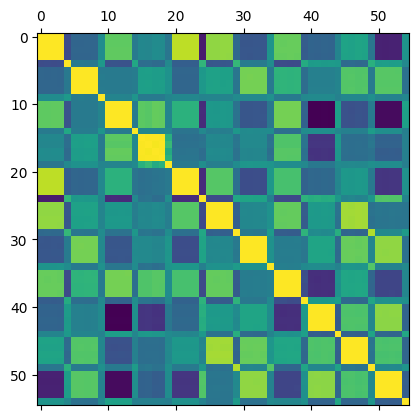

In [5]:
plt.matshow(data.corr())

In [6]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

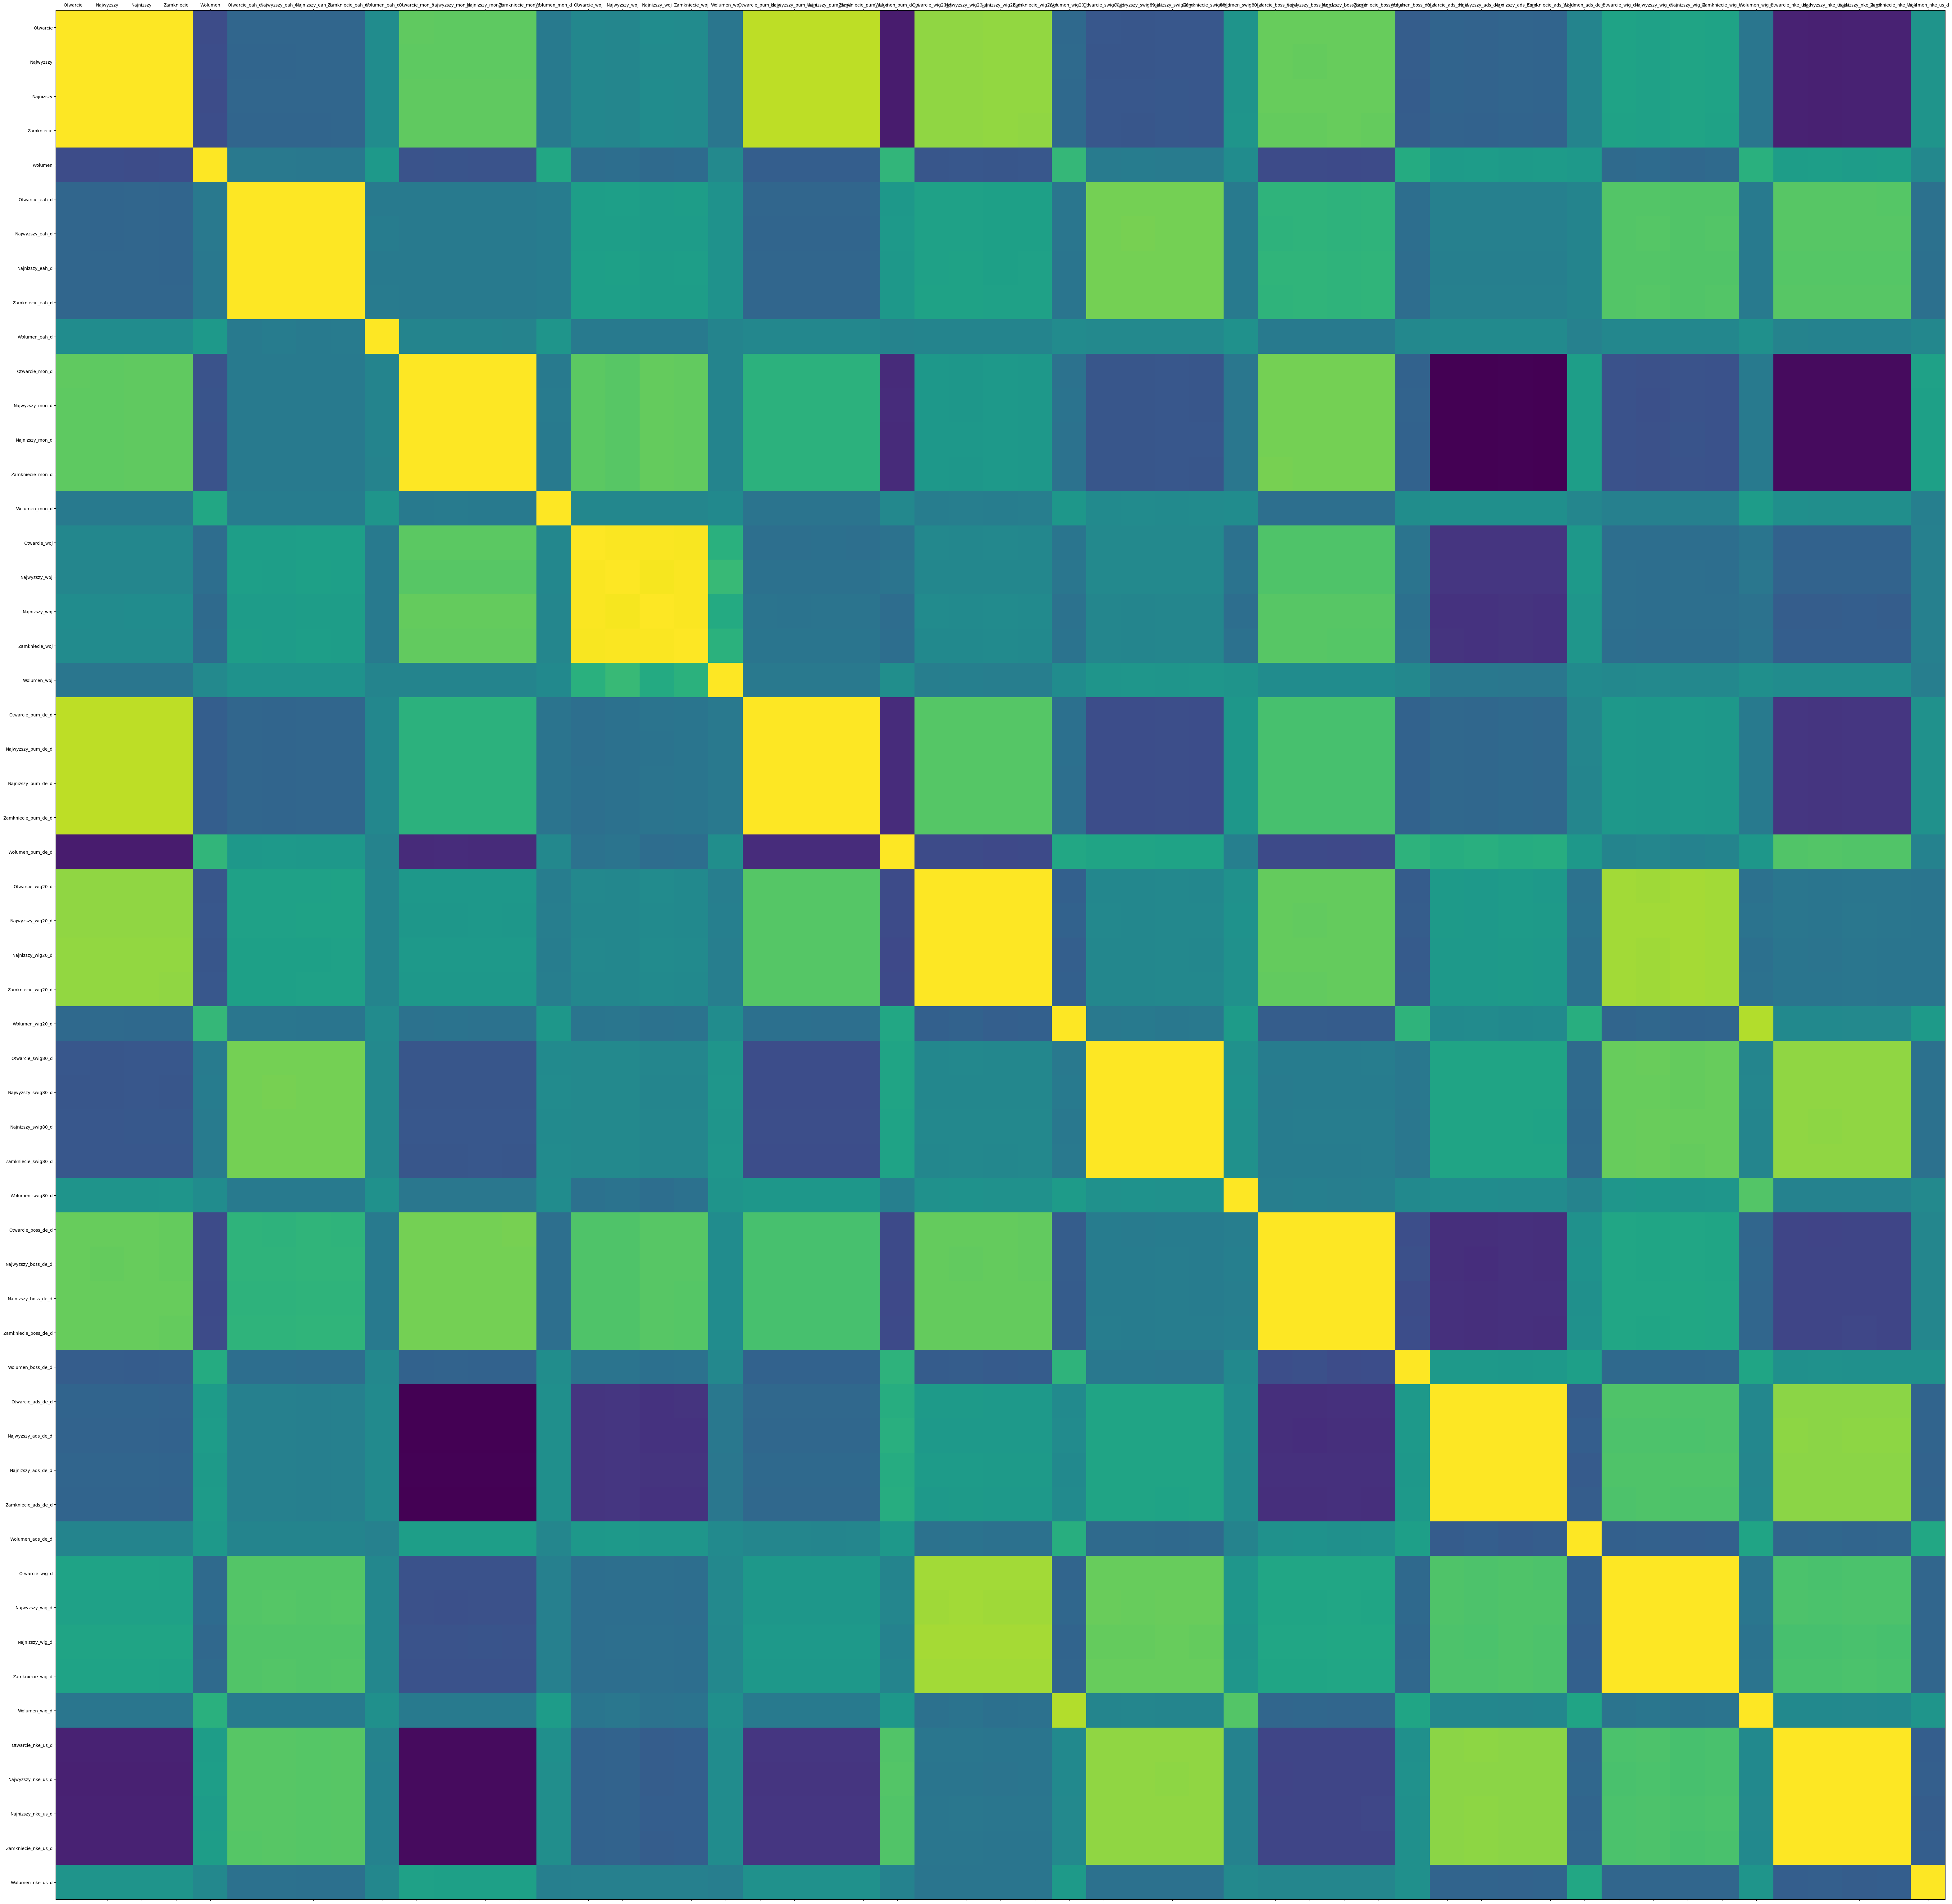

In [ ]:
plot_corr(data,79)

In [7]:
corr = data.corr()
corr.style.background_gradient()

<ipython-input-7-c52c03f6803f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Otwarcie_eah_d,Najwyzszy_eah_d,Najnizszy_eah_d,Zamkniecie_eah_d,Wolumen_eah_d,Otwarcie_mon_d,Najwyzszy_mon_d,Najnizszy_mon_d,Zamkniecie_mon_d,Wolumen_mon_d,Otwarcie_woj,Najwyzszy_woj,Najnizszy_woj,Zamkniecie_woj,Wolumen_woj,Otwarcie_pum_de_d,Najwyzszy_pum_de_d,Najnizszy_pum_de_d,Zamkniecie_pum_de_d,Wolumen_pum_de_d,Otwarcie_wig20_d,Najwyzszy_wig20_d,Najnizszy_wig20_d,Zamkniecie_wig20_d,Wolumen_wig20_d,Otwarcie_swig80_d,Najwyzszy_swig80_d,Najnizszy_swig80_d,Zamkniecie_swig80_d,Wolumen_swig80_d,Otwarcie_boss_de_d,Najwyzszy_boss_de_d,Najnizszy_boss_de_d,Zamkniecie_boss_de_d,Wolumen_boss_de_d,Otwarcie_ads_de_d,Najwyzszy_ads_de_d,Najnizszy_ads_de_d,Zamkniecie_ads_de_d,Wolumen_ads_de_d,Otwarcie_wig_d,Najwyzszy_wig_d,Najnizszy_wig_d,Zamkniecie_wig_d,Wolumen_wig_d,Otwarcie_nke_us_d,Najwyzszy_nke_us_d,Najnizszy_nke_us_d,Zamkniecie_nke_us_d,Wolumen_nke_us_d
Otwarcie,1.000000,0.999503,0.999440,0.997436,-0.393220,-0.220552,-0.220396,-0.218721,-0.216481,0.065533,0.552686,0.550992,0.552211,0.551579,-0.078094,0.021545,0.016676,0.062745,0.056674,-0.106490,0.818007,0.817413,0.819574,0.818883,-0.677996,0.701594,0.699621,0.705724,0.702453,-0.195744,-0.326692,-0.330949,-0.321684,-0.325998,0.124292,0.577172,0.574461,0.579527,0.576989,-0.284134,-0.232952,-0.240234,-0.226032,-0.233215,0.003767,0.234862,0.225475,0.246803,0.236102,-0.105722,-0.646416,-0.650753,-0.642463,-0.646863,0.123979
Najwyzszy,0.999503,1.000000,0.999379,0.997951,-0.386437,-0.222339,-0.222140,-0.220501,-0.218207,0.065297,0.551066,0.549491,0.550620,0.550085,-0.075921,0.019721,0.015148,0.060897,0.055183,-0.106500,0.819192,0.818613,0.820777,0.820087,-0.677503,0.700361,0.698927,0.704796,0.701900,-0.192538,-0.329313,-0.333434,-0.324205,-0.328417,0.124521,0.574870,0.572281,0.577270,0.574809,-0.282204,-0.231320,-0.238512,-0.224366,-0.231482,0.004978,0.233004,0.224061,0.245212,0.234824,-0.103100,-0.646301,-0.650624,-0.642375,-0.646776,0.123883
Najnizszy,0.999440,0.999379,1.000000,0.998097,-0.398236,-0.220453,-0.220171,-0.218461,-0.216139,0.065965,0.555320,0.553700,0.554967,0.554380,-0.077507,0.023952,0.019022,0.065557,0.059516,-0.105987,0.816010,0.815415,0.817669,0.816937,-0.680132,0.700614,0.698936,0.705430,0.702264,-0.198494,-0.323863,-0.328046,-0.318554,-0.322872,0.123398,0.577669,0.575018,0.580205,0.577678,-0.286264,-0.235976,-0.243233,-0.228878,-0.236069,-0.000582,0.234334,0.225198,0.246922,0.236296,-0.107807,-0.647009,-0.651373,-0.642977,-0.647429,0.122812
Zamkniecie,0.997436,0.997951,0.998097,1.000000,-0.391107,-0.224863,-0.224489,-0.222833,-0.220448,0.067127,0.554830,0.553369,0.554504,0.554105,-0.074861,0.022389,0.017775,0.064080,0.058423,-0.105454,0.816063,0.815414,0.817733,0.816991,-0.681264,0.696541,0.695335,0.701742,0.699215,-0.195864,-0.325627,-0.329683,-0.320237,-0.324374,0.126805,0.573383,0.570850,0.576039,0.573612,-0.284970,-0.236381,-0.243566,-0.229191,-0.236280,-0.000712,0.229788,0.221031,0.242681,0.232606,-0.103055,-0.647743,-0.652041,-0.643631,-0.647981,0.123727
Wolumen,-0.393220,-0.386437,-0.398236,-0.391107,1.000000,-0.086316,-0.083747,-0.089377,-0.088657,0.161534,-0.352194,-0.348835,-0.352863,-0.350914,0.273491,-0.171550,-0.159015,-0.190485,-0.180132,0.037168,-0.274563,-0.273656,-0.275996,-0.274800,0.379951,-0.330572,-0.321836,-0.335643,-0.328050,0.394935,-0.059588,-0.055717,-0.063615,-0.059885,0.066377,-0.402974,-0.399769,-0.406714,-0.403839,0.301136,0.178319,0.184976,0.172815,0.179578,0.165096,-0.192769,-0.182323,-0.201589,-0.191591,0.336030,0.193337,0.197817,0.188275,0.193410,0.026821
Otwarcie_eah_d,-0.220552,-0.222339,-0.220453,-0.224863,-0.086316,1.000000,0.998544,0.998511,0.997745,-0.068651,-0.076545,-0.075184,-0.075824,-0.074743,-0.056982,0.202402,0.207751,0.189630,0.191273,0.110397,-0.220230,-0.220080,-0.221078,-0.221063,0.153796,0.220380,0.222842,0.212782,0.216046,-0.105746,0.619813,0.620173,0.618557,0.618486,-0.068922,0.362445,0.366280,0.360408,0.364226,-0.162996,-0.027555,-0.027060,-0.028933,-0.029366,0.003

In [8]:
corr.to_csv('correlations.csv')

In [10]:
from sklearn.preprocessing import MinMaxScaler

class BatchedData():
    from sklearn.preprocessing import MinMaxScaler

    def __init__(self,data,num_days,scaler=MinMaxScaler()):
        self.scaler = scaler
        self.data = data
        self.num_days = num_days
        
        #ogólnie zmienne z literą "X" dotyczą zbioru wejściowego, natomiast z literą "Y" dotyczą zbioru wyjściowego
        
        self.X = self.scaler.fit_transform(self.data.drop(columns=['Data','Zamkniecie']))#normalizacja danych i usunięcie kolumn, które nie mają być danymi wejściowymi
        self.y = self.data['Zamkniecie'].values/np.max(self.data['Zamkniecie'])#wartość kolumny "Zamknięcie" jest prognozowana na wyjściu sieci
        
        self.rng = np.random.randint(1,len(self.data)-self.num_days)#losowe wybieranie rekordów do zbiorów testowych i uczących
        self.x_batch = self.X[self.rng:self.rng+self.num_days,:]
        self.y_batch = self.y[self.rng-1]

    def nextBatch(self):
        rng = np.random.randint(1,len(self.data)-self.num_days)
        
        while(True):
            rng = np.random.randint(1,len(self.data)-self.num_days)
            
            if rng != self.rng:
                self.rng = rng
                break
                
        self.x_batch = self.X[self.rng:self.rng+self.num_days,:].reshape([self.num_days,self.X.shape[1]])
        self.y_batch = self.y[self.rng-1]
        
    def createDataset(self):
        train_range = int(len(self.data) * 0.8)# zbiór uczący
        test_range = int(len(self.data) * 0.2)#zbiór testowy
        
        self.X_train = np.zeros([train_range,num_days,self.X.shape[1]])
        self.Y_train = np.zeros([train_range])

        for i in range(train_range):
            self.nextBatch()
            self.X_train[i,:,:] = self.x_batch
            self.Y_train[i] = self.y_batch

        self.X_test = np.zeros([test_range,num_days,self.X.shape[1]])
        self.Y_test = np.zeros([test_range])

        for i in range(test_range):
            self.nextBatch()
            self.X_test[i,:,:] = self.x_batch
            self.Y_test[i] = self.y_batch

In [11]:
num_days = 7 #liczba dni historycznych
batched_data = BatchedData(data,num_days)
batched_data.createDataset()#utworzony jest zbiór z danymi historycznymi

len(np.unique(batched_data.Y_train))

902

In [12]:
data_size = int(batched_data.x_batch.shape[1])
#print(data_size)
#tworzenie modelu
model = Sequential()

model.add(LSTM(units=55,activation='relu',input_shape=[num_days,data_size],return_sequences=True))
#tworzenie warstwy LSTM, podajemy liczbę neuronow, rodzaj funkcji aktywacji, liczbę historycznych notowań, rozmiar danych, zwracana jest sekwencja danych taka, jaka jest liczba historycznych notowań

model.add(Dropout(rate=0.6))


model.add(LSTM(units=30,activation='softmax',return_sequences=True))
model.add(Dropout(rate=0.3))

model.add(LSTM(units=16,activation='relu',return_sequences=True))
model.add(LSTM(units=8,activation='relu',return_sequences=True))
model.add(Dropout(rate=0.3))

model.add(LSTM(units=4,activation='sigmoid',return_sequences=True))
model.add(Flatten())
model.add(Dense(units=1,activation='sigmoid'))


In [13]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])#kompilacja modelu, funkcja oceny i metryka to błąd średniokwadratowy

In [14]:
epochs = 60 #liczba epok uczących
batch=32
#uczenie modelu, podajemy jako parametry dane ze zbioru uczącego (wejście i wyjćie) i dane ze zbioru testowego (wejście i wyjćie)

history = model.fit(batched_data.X_train,batched_data.Y_train,
                    validation_data=(batched_data.X_test,batched_data.Y_test),
                    epochs=epochs,
                    batch_size=batch)

Epoch 1/60
46/46 [==============================] - 10s 41ms/step - loss: 0.0559 - mse: 0.0559 - val_loss: 0.0633 - val_mse: 0.0633
Epoch 2/60
46/46 [==============================] - 1s 23ms/step - loss: 0.0521 - mse: 0.0521 - val_loss: 0.0621 - val_mse: 0.0621
Epoch 3/60
46/46 [==============================] - 1s 21ms/step - loss: 0.0497 - mse: 0.0497 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 4/60
46/46 [==============================] - 1s 21ms/step - loss: 0.0323 - mse: 0.0323 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 5/60
46/46 [==============================] - 1s 23ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 6/60
46/46 [==============================] - 1s 21ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0173 - val_mse: 0.0173
Epoch 7/60
46/46 [==============================] - 1s 32ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0168 - val_mse: 0.0168
Epoch 8/60
46/46 [==============================] - 2s 33ms/step - loss: 0.0117 - 

In [19]:
print(history.history['val_loss'])


[0.06328239291906357, 0.062091365456581116, 0.04787829518318176, 0.02971978671848774, 0.020052431151270866, 0.01727813482284546, 0.01681426726281643, 0.011506476439535618, 0.010271232575178146, 0.009635667316615582, 0.007480231579393148, 0.006196228787302971, 0.005878171883523464, 0.005407379940152168, 0.005034299101680517, 0.005040248855948448, 0.004874799400568008, 0.0045720720663666725, 0.004345766268670559, 0.0040051983669400215, 0.003601168980821967, 0.00302967824973166, 0.00270174746401608, 0.002534800209105015, 0.002323815831914544, 0.002214855281636119, 0.0019649481400847435, 0.0021468144841492176, 0.0017798395128920674, 0.0015657057520002127, 0.0014181853039190173, 0.0015423042932525277, 0.0011442209361121058, 0.0010748655768111348, 0.0011541522108018398, 0.0009295488707721233, 0.001050742226652801, 0.0012379722902551293, 0.0009984092321246862, 0.0007673960644751787, 0.0008218461880460382, 0.0007776812999509275, 0.0007236363017000258, 0.0008198504219762981, 0.00075850856956094

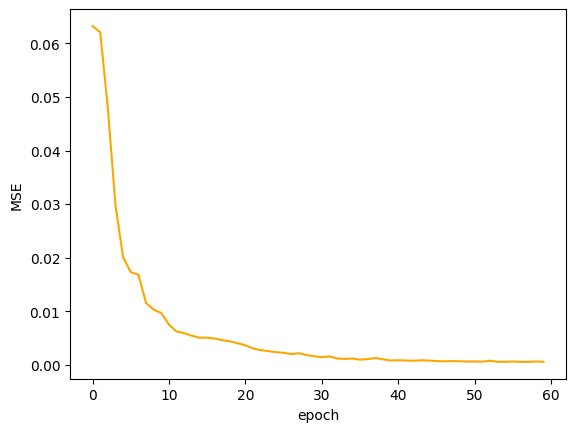

In [20]:
plt.plot(history.history['val_loss'],color='orange')#wykres procesu uczenia się - wyniki danych testowych
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

In [21]:
Y_pred=model.predict(batched_data.X_test)#dokonujemy predykcji z wykorzystaniem nauczonego modelu


12/12 [==============================] - 0s 8ms/step


In [22]:
for i in range(len(batched_data.Y_test)):
            print(Y_pred[i,0],'\t',batched_data.Y_test[i]) #wyświetlenie wartości prognozowanych i faktycznych


0.13506353 	 0.1245816654636131
0.5981588 	 0.5914758186232694
0.58153594 	 0.5851105715598137
0.17674041 	 0.2030316949931098
0.16335179 	 0.15325808780103684
0.38429528 	 0.3756808189513748
0.6958093 	 0.6945009515060043
0.80100244 	 0.8039897631078156
0.8771472 	 0.9158409344445174
0.51905966 	 0.5090229017652077
0.6108927 	 0.5910820920007875
0.6866338 	 0.6796049609554433
0.8665915 	 0.8220027560863574
0.5822421 	 0.5836669072773805
0.8732324 	 0.8522540849137084
0.14594275 	 0.15644071133276463
0.8755245 	 0.9404488483496293
0.3404005 	 0.34287026707789225
0.18675885 	 0.20572216024673537
0.13506353 	 0.1253363081567032
0.87828326 	 1.0
0.5356581 	 0.5317934247654046
0.13895556 	 0.14436642824332307
0.41689342 	 0.41387230133210845
0.64100146 	 0.6407900780891136
0.5439425 	 0.5387492617625829
0.7571072 	 0.76097512960168
0.5181302 	 0.5070542686527988
0.17670484 	 0.20185051512566443
0.17438368 	 0.1887919154800184
0.13506353 	 0.10919351663494982
0.38990587 	 0.3984841525034451